In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error ,root_mean_squared_error

In [2]:
# Load the data and create engineered features
df = pd.read_csv('../../data/data.csv')
# Convert date columns to datetime
df[["observation_date", "date_of_introduction"]] = df[["observation_date", "date_of_introduction"]].apply(
    pd.to_datetime
)
# create number of days since introduction feature
df['days_since_introduction'] = (df['observation_date'] - df['date_of_introduction']).dt.days
df['initial_growth_potential'] = df['initial_female_count'] * df['leaf_area_cm2']

In [4]:
# 1. Define features and target
# We use the core engineered features, NOT the polynomial or log-transformed ones
features = [
    'initial_female_count',
    'leaf_area_cm2',
    'population_density',
    'days_since_introduction',
    'initial_growth_potential'
]
target = 'cumulative_mite_count'

X = df[features]
y = df[target]

# 2. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Create and train the Random Forest model
# n_estimators=100 is a good starting point
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True)
rf_model.fit(X_train, y_train)

# 4. Make predictions and evaluate
y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mean_squared_error_rf = mean_squared_error(y_test, y_pred_rf)
root_mean_squared_error_rf = root_mean_squared_error(y_test, y_pred_rf)

# 5. Print the results and compare
print("--- Random Forest Regressor Performance ---")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {root_mean_squared_error_rf:.2f}")
print(f"R-squared (R²): {r2_rf:.4f}")

print("--- Comparison ---")
print(f"Best Linear Model R²: 0.8309")
print(f"Random Forest R²:     {r2_rf:.4f}")

--- Random Forest Regressor Performance ---
Mean Absolute Error (MAE): 35.14
Mean Squared Error (MSE): 3877.77
Root Mean Squared Error (RMSE): 62.27
R-squared (R²): 0.8045
--- Comparison ---
Best Linear Model R²: 0.8309
Random Forest R²:     0.8045


In [9]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 1. Define the Hyperparameter Grid ---
# We are creating a "menu" of settings for the search to try.
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 750], # Number of trees in the forest
    'max_features': ['sqrt', 'log2', 1.0],      # Number of features to consider at every split
    'max_depth': [10, 20, 30, None],          # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 15],          # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4, 6]             # Minimum number of samples required at each leaf node
}


# --- 2. Set up and Run Randomized Search ---
rf = RandomForestRegressor(random_state=42)

# cv=5 means it will use 5-fold cross-validation
rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,n_iter=500,
     cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model (this might take a few minutes)
rf_random_search.fit(X_train, y_train)


# --- 3. Evaluate the Best Model ---
# The search object automatically saves the best performing model
best_rf_model = rf_random_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
mean_squared_error_best_rf = mean_squared_error(y_test, y_pred_best_rf)
root_mean_squared_error_best_rf = root_mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print("\n--- Tuned Random Forest Regressor Performance ---")
print(f"Best Parameters Found: {rf_random_search.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_best_rf:.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error_best_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {root_mean_squared_error_best_rf:.2f}")
print(f"R-squared (R²): {r2_best_rf:.4f}\n")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits

--- Tuned Random Forest Regressor Performance ---
Best Parameters Found: {'n_estimators': 750, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 10}
Mean Absolute Error (MAE): 33.88
Mean Squared Error (MSE): 3327.71
Root Mean Squared Error (RMSE): 57.69
R-squared (R²): 0.8322



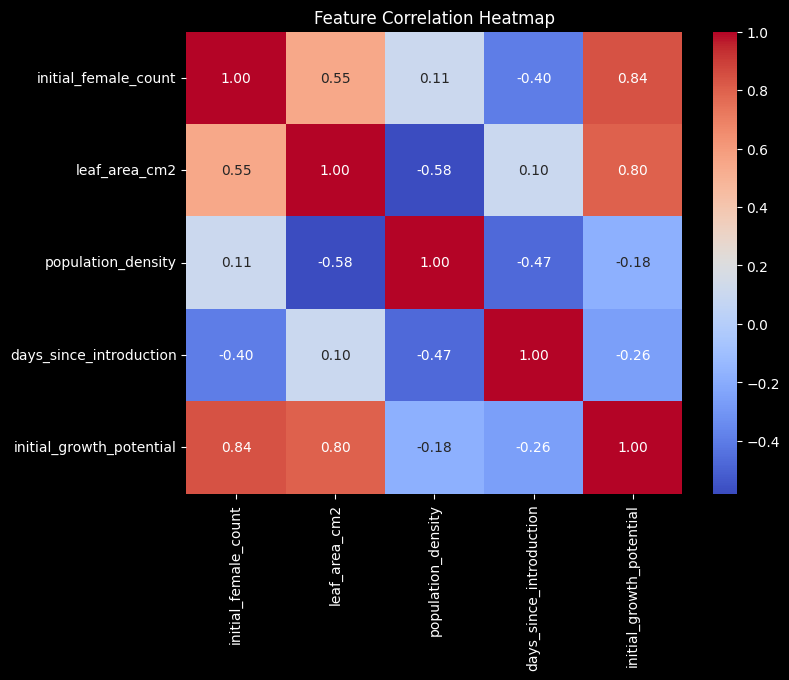

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = X.corr()

# Visualize correlation
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()